In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import json
import mlflow
import torch
from hcmus.core import appconfig
from hcmus.data import CroppedImageDatasetV2
from hcmus.utils import data_utils
from torchvision import transforms as T

In [3]:
logged_model = 'runs:/415b1f0c9b8640d9848e0fc470528ecc/model'
model = mlflow.pyfunc.load_model(logged_model).get_raw_model()

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/07/12 18:52:40 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - jaraco-collections (current: uninstalled, required: jaraco-collections==5.1.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


In [ ]:
label2idx_path = mlflow.artifacts.download_artifacts("mlflow-artifacts:/4/415b1f0c9b8640d9848e0fc470528ecc/artifacts/json/label2idx.json")
label2idx = json.load(open(label2idx_path))

In [108]:
split_name = "val"
label2idx["object"] = -1
splits = data_utils.get_data_splits([split_name], labels=label2idx)

2025-07-12 21:12:32.538 | WARNING  | hcmus.lbs._label_studio_connector:get_tasks:148 - Page size is too large, only 309 tasks available.
2025-07-12 21:12:32.539 | INFO     | hcmus.lbs._label_studio_connector:get_tasks:152 - New `page_to` applied: 4
Loading tasks: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


In [ ]:
transform_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [109]:
data_list = splits[split_name]
dataset = CroppedImageDatasetV2(data_list, label2idx, transforms=transform_test)

2025-07-12 21:12:39.954 | INFO     | hcmus.data._torch_dataset_v2:__init__:55 - Apply random_margin=0.0


In [110]:
grouped_labels = {}
for i, item in enumerate(dataset.samples):
    idx = item.get("label_idx")
    if idx not in grouped_labels:
        grouped_labels[idx] = []
    grouped_labels[idx].append(i)

In [111]:
from tqdm import tqdm
from torch.nn import functional as F
from collections import defaultdict

def compute_entropy(probs):
    log_probs = torch.log(probs + 1e-12)  # Avoid log(0)
    entropy = -torch.sum(probs * log_probs, dim=-1)
    return entropy

label_stats = defaultdict(list)
for label_idx, ls in tqdm(grouped_labels.items(), "Processing..."):
    for i in ls:
        img, label, metadata = dataset[i]
        logits = model(img)
        probs = F.softmax(logits, dim=-1)
        entropy = compute_entropy(probs)
        prob = probs.max()
        label_stats[label_idx].append({
            "entropy": entropy.item(),
            "prob": prob.item()
        })

Processing...: 100%|██████████| 99/99 [07:08<00:00,  4.33s/it]  


In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = []

for k, v in label_stats.items():
    for stat in v:
        df.append({
            "label": k,
            "entropy": stat["entropy"],
            "prob": stat["prob"]
        })

df = pd.DataFrame(df)
df["group"] = "known"
df.loc[df["label"] == -1, "group"] = "unknown"


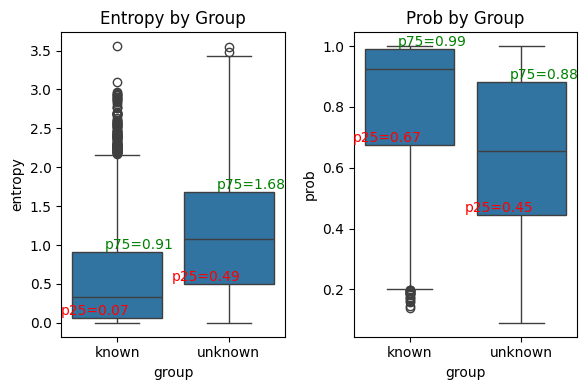

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

metrics = ['entropy', 'prob']

for ax, metric in zip(axes, metrics):
    # Draw the boxplot
    sns.boxplot(x='group', y=metric, data=df, ax=ax)
    ax.set_title(f'{metric.capitalize()} by Group')

    # Annotate p25 and p75
    for i, group in enumerate(df['group'].unique()):
        values = df[df['group'] == group][metric]
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)

        # Add annotations slightly offset for clarity
        ax.text(i - 0.2, q1, f'p25={q1:.2f}', color='red', ha='center', va='bottom')
        ax.text(i + 0.2, q3, f'p75={q3:.2f}', color='green', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# strategy 1: predict unknown if entropy >= 0.49
# strategy 2: predict unknown if prob < 0.88